In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Synthetic Data Generation

In [2]:
def Lorentz_System(state, sigma, rho, beta):
    x, y, z = state
    x_dot = sigma*(y-x)
    y_dot = x*(rho-z) - y
    z_dot = x*y - beta*z

    return np.array([x_dot, y_dot, z_dot])

Before attempting RK4, we stress-test the Lorenz integrator with a simple explicit Euler step: by sweeping Δt values and flagging any run where |x|, |y|, or |z| exceeds a large threshold (e.g., 10³) as “blew up,” we identify the maximum Δt that remains bounded over a fixed simulation window. This is crucial because if solutions blow up the simulation fails catastrophically, and we need Δt values that keep the orbit inside the true Lorenz attractor rather than rocketing off to ±∞. If the discrete points drift far outside the real attractor, we are no longer simulating the Lorenz system but instead generating spurious divergent trajectories; any ML model you train expects data reflecting the true chaotic dynamics, and blow-up paths violate that assumption and destroy the validity of everything that follows. Since Euler is only first-order accurate (and thus more prone to instability), any Δt that survives this aggressive stress test will nearly always be stable—and even more accurate—when used with a higher-order method like RK4. In practice, if Euler blows up at Δt = 0.1, you know to choose Δt ≪ 0.1 for RK4 to faithfully reconstruct the Lorenz attractor without trajectories flying off to infinity.


In [3]:
def Lorentz_Euler_Step(state, sigma, rho, beta, dt):
    deriv = Lorentz_System(state, sigma, rho, beta)
    return state + (deriv * dt)
    

dt = 1      → BLEW UP


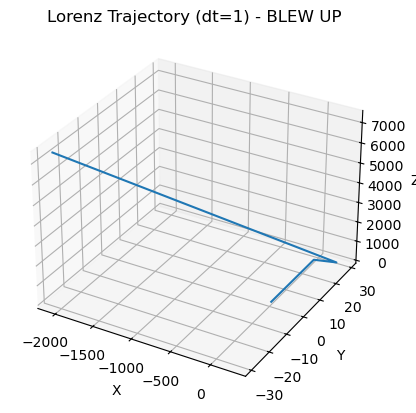

dt = 0.1    → BLEW UP


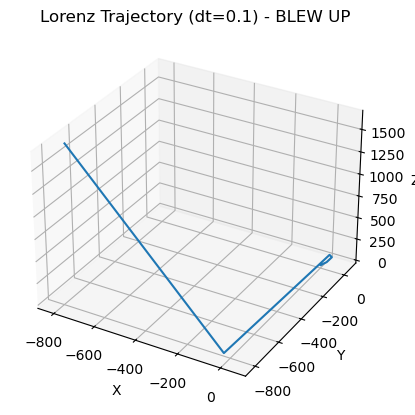

dt = 0.01   → Stable


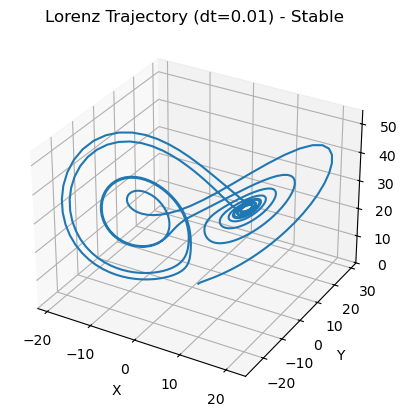

dt = 0.001  → Stable


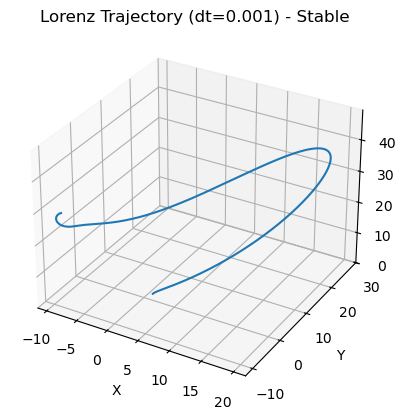

dt = 0.0001 → Stable


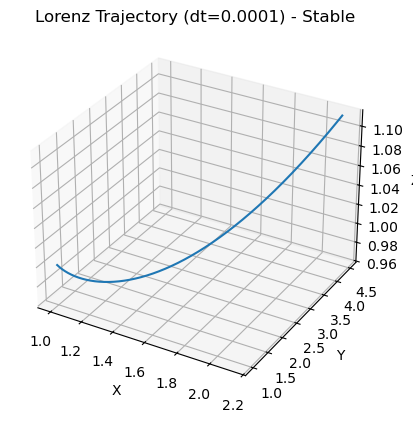

In [4]:
# Initial Conditions
sigma, rho, beta = 10.0, 28.0, (8.0/3.0)
x0, y0, z0 = 1.0, 1.0, 1.0

for dt in [1, 0.1, 0.01, 0.001, 0.0001]:
    state = np.array([x0, y0, z0])
    states = [state.copy()]
    blew_up = False

    for i in range(1000):
        state = Lorentz_Euler_Step(state, sigma, rho, beta, dt)
        states.append(state.copy())

        if np.linalg.norm(state) > 1e3:
            blew_up = True
            break;

    if blew_up == True:
        status = "BLEW UP"
    else:
        status = "Stable"

    print(f"dt = {dt:<6} → {status}")

    states = np.array(states)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(states[:,0], states[:,1], states[:,2])
    ax.set_title(f"Lorenz Trajectory (dt={dt}) - {status}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
        

| Δt      | What Happened              | Why                                                                                         |
|---------|----------------------------|---------------------------------------------------------------------------------------------|
| **1**       | Blew up                    | The step is too large; numerical errors grow without bound.                                 |
| **0.1**     | Blew up                    | The step is still too large; the solution diverges to infinity.                            |
| **0.01**    | Stable, butterfly shape    | Captures the classic Lorenz “butterfly” loops without blowing up.                           |
| **0.001**   | Stable, smooth curve       | Very small step; trajectory evolves smoothly but requires many iterations to see loops.    |
| **0.0001**  | Stable, very smooth curve  | Step is tiny; extremely accurate but computationally expensive with little added benefit.  |
|             |                            | Making Δt smaller just produces more points on the same trajectory, but does not reveal new 
                                             dynamics or features of the attractor (wastes computational time because trajectory evolves 
                                             slowly

**Why we choose Δt = 0.01:**

- Δt = 0.01 already gives you trajectories that accurately follow the true Lorenz attractor. We can clearly see the butterly structure emerge during simulation, which is critical for both validating the simulation and training machine learning models that rely on true chaotic dynamics.
- It is small enoguh to accurately track the chaotic jumps between the two wings of the Lorenz attractor without the trajectory blowing up.
- It is large enough that we can simulate a meaningful portion of the attractor (multiple butterfly loops) within a reasonable number of steps, avoiding excessive computation time.
- Since Euler is stable at Δt = 0.01, it guarantees that Runge–Kutta 4 (RK4) — a higher-order, more accurate method — will be even more stable and precise at the same step size.


In [5]:
def rk4(state, dt, sigma, rho, beta):
    k1 = Lorentz_System(state, sigma, rho, beta)
    k2 = Lorentz_System(state + 0.5 * dt * k1, sigma, rho, beta)
    k3 = Lorentz_System(state + 0.5 * dt * k2, sigma, rho, beta)
    k4 = Lorentz_System(state + dt * k3, sigma, rho, beta)

    return state + (dt*((k1 + 2*k2 + 2*k3 + k4)/6.0))
    

Now, let's visualize the Lorenz attractor using N = 30000

In [6]:
dt = 0.01
N = 30000
sigma, rho, beta = 10.0, 28.0, 8.0/3.0
state = np.array([x0, y0, z0])

trajectory = np.empty((N+1, 3))
trajectory[0] = state

for i in range(1, N+1):
    state = rk4(state, dt, sigma, rho, beta)
    trajectory[i] = state

# Subsample trajectory to plot fewer points
thin = trajectory[::1]

fig = plt.figure(figsize=(20, 5))

# 3D
ax0 = fig.add_subplot(1, 4, 1, projection='3d')
ax0.plot(thin[:, 0], thin[:, 1], thin[:, 2], lw=0.5)
ax0.set_xlabel('x(t)'); ax0.set_ylabel('y(t)'); ax0.set_zlabel('z(t)')
ax0.set_title('3D View')
ax0.set_box_aspect((1,1,1))  # equal aspect in 3D

# XY
ax1 = fig.add_subplot(1, 4, 2)
ax1.plot(thin[:, 0], thin[:, 1], lw=0.5)
ax1.set_xlabel('x(t)'); ax1.set_ylabel('y(t)')
ax1.set_title('XY Projection')
ax1.set_aspect('equal', 'box')

# YZ
ax2 = fig.add_subplot(1, 4, 3)
ax2.plot(thin[:, 1], thin[:, 2], lw=0.5)
ax2.set_xlabel('y(t)'); ax2.set_ylabel('z(t)')
ax2.set_title('YZ Projection')
ax2.set_aspect('equal', 'box')

# XZ
ax3 = fig.add_subplot(1, 4, 4)
ax3.plot(thin[:, 0], thin[:, 2], lw=0.5)
ax3.set_xlabel('x(t)'); ax3.set_ylabel('z(t)')
ax3.set_title('XZ Projection')
ax3.set_aspect('equal', 'box')

plt.tight_layout()
plt.show()

For the actual experiment, we would want a much denser samplign of the attractor. This would act as more reliable traning data for the neural network and it would let them learn richer dynamics. Moreover, we would get more stable, reproducible results when comparing different models or noise levels.

In [7]:
dt = 0.01
N = 500000
sigma, rho, beta = 10.0, 28.0, 8.0/3.0
state = np.array([x0, y0, z0])

trajectory = np.empty((N+1, 3))
trajectory[0] = state

for i in range(1, N+1):
    state = rk4(state, dt, sigma, rho, beta)
    trajectory[i] = state

In [8]:
print("First point of full trajectory:", trajectory[0])
print("Second point of full trajectory:", trajectory[1])
print("Third point of full trajectory:", trajectory[2])


First point of full trajectory: [1. 1. 1.]
Second point of full trajectory: [1.01256719 1.2599178  0.98489097]
Third point of full trajectory: [1.04882371 1.52399713 0.97311422]


# Add Noise

### Observational Noise

In [18]:
noise_levels = [0, 0.005, 0.01, 0.05, 0.1]  # 0%, 0.5%, 1%, 5%, 10%
train_noisy = {}
val_noisy   = {}
test_noisy  = {}

rng = np.random.default_rng(42)   # This is done so that every time you run your notebook, you get the same noise

for nl in noise_levels:
    train_noisy[nl] = train_data + nl * rng.standard_normal(size=train_data.shape)
    val_noisy[nl]   = val_data   + nl * rng.standard_normal(size=val_data.shape)
    test_noisy[nl]  = test_data  + nl * rng.standard_normal(size=test_data.shape)

### Structural Noise

In [19]:
def add_structural_noise(data, amp=0.1, period=1000):
    N = data.shape[0]
    t = np.arange(N)
    drift = 1.0 + amp * np.sin(2 * np.pi * t/period)      # range [0.9,1.1]
    out = data.copy()
    out[:,1] *= drift  # apply to y–axis (second variable) only
    return out

In [20]:
train_struct = add_structural_noise(train_data, amp=0.1, period=1000)
val_struct   = add_structural_noise(val_data,   amp=0.1, period=1000)
test_struct  = add_structural_noise(test_data,  amp=0.1, period=1000)

# Combined Noise: Both Observational + Structural 

In [21]:
noisy_both = {}

for nl in noise_levels:
    # Observation Noise
    train_obs = train_data + nl * rng.standard_normal(train_data.shape)
    val_obs   = val_data   + nl * rng.standard_normal(val_data.shape)
    test_obs  = test_data  + nl * rng.standard_normal(test_data.shape)

    # b) Structural Noise
    train_comb = add_structural_noise(train_obs, amp=0.1, period=1000)
    val_comb   = add_structural_noise(val_obs,   amp=0.1, period=1000)
    test_comb  = add_structural_noise(test_obs,  amp=0.1, period=1000)

    noisy_both[nl] = {
        "train": train_comb,
        "val":   val_comb,
        "test":  test_comb
    }


# Feed Forward Neural Network

In [30]:
def make_windows(trajectory, window_size, horizon = 1):
    # horizon is the number of steps ahead to predict

    N = trajectory.shape[0]
    X, y = [], []

    for i in range(N - window_size - horizon + 1):
        X.append(trajectory[i : i + window_size])
        y.append(trajectory[i + window_size : i + window_size + horizon])

    return np.array(X), np.array(y)

# Neural Network Class

In [32]:
class NeuralNetwork:
    def __init__(self, input_size = 64, hidden_size = 30, output_size = 10, learning_rate = 1e-3, epochs = 1000):
        # Hyperparameters
        self.learning_rate = learning_rate
        self.epochs = epochs
        
        # Weights & bias initialization with small random values
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01  
        self.b1 = np.zeros((1, hidden_size))                       
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01 
        self.b2 = np.zeros((1, output_size))                       #

    # ReLU activation function
    def ReLU(self, x):
        return np.maximum(0, x)

    # Derivative of the ReLU function
    def ReLU_deriv(self, x):
        return np.where(x > 0, 1, 0)

    # Linear Activation Function
    def Linear(self, x):
        return x

    def Linear_deriv(self, x):
        return np.ones_like(x)

    # Forward propagation: computes the activations for the hidden and output layers
    def forward_propagation(self, x):
        # Hidden layer
        self.z1 = x @ self.W1 + self.b1
        self.a1 = self.ReLU(self.z1)
    
        # Output layer
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.Linear(self.z2)
        
        return self.a2

    # Compute the cost using Mean Squared Error
    def compute_cost(self, y_pred, y_true):
        return np.mean((y_pred - y_true)**2)

    # Back propagation: computes gradients for updating weights and biases
    def back_propagation(self, x, y):       
        m = y.shape[0]
    
        # Compute error at output layer
        error2 = 2 * (self.a2 - y) * self.Linear_deriv(self.z2)

        # Compute gradients for weights and biases for the output layer
        grad_W2 = (self.a1.T @ error2) / m
        grad_b2 = np.sum(error2, axis = 0, keepdims = True) / m

        # Backpropagate the error to the hidden layer
        error1 = (error2 @ self.W2.T) * self.ReLU_deriv(self.z1)

        # Compute gradients for weights and biases for the hidden layer
        grad_W1 = (x.T @ error1) / m
        grad_b1 = np.sum(error1, axis = 0, keepdims = True) / m

        return grad_W1, grad_b1, grad_W2, grad_b2

    # Update the network parameters (weights and biases) using the computed gradients
    def update_parameters(self, grad_W1, grad_b1, grad_W2, grad_b2):
        self.W2 = self.W2 - (self.learning_rate * grad_W2)
        self.b2 = self.b2 - (self.learning_rate * grad_b2)
        self.W1 = self.W1 - (self.learning_rate * grad_W1)
        self.b1 = self.b1 - (self.learning_rate * grad_b1)

    # Train the neural network by iterating over epochs
    def train(self, x, y):
        for epoch in range(self.epochs):
            # Perform forward propagation to get outputs
            Y_pred = self.forward_propagation(x)

            # Compute gradients via back propagation
            grad_W1, grad_b1, grad_W2, grad_b2 = self.back_propagation(x, y)

            # Update network parameters with the gradients
            self.update_parameters(grad_W1, grad_b1, grad_W2, grad_b2)

            # Every 100 epochs, compute and print the cost for monitoring convergence
            if (epoch%100 == 0):
                cost = self.compute_cost(Y_pred, y)
                print(f"Epoch {epoch}, Cost: {cost}")

    # Predict class labels for input data
    def predict(self, x):
        return self.forward_propagation(x)

# Training the Neural Network

In [ ]:
window_size = 20
horizon     = 1

X, y = make_windows(trajectory, window_size, horizon)

### Splitting into Training, Validation, and Test Set

In [ ]:
n = X.shape[0]
n_train = int(0.70*n)
n_val   = int(0.15*n)

X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:], y[n_train+n_val:]

In [ ]:
print(f"Total points: {N}")
print(f"  Training : {X_train.shape[0]} samples")
print(f"  Validation: {X_val.shape[0]} samples")
print(f"  Testing  : {X_test.shape[0]} samples")

### Normalizing the Data Points

In [ ]:
eps = 1e-8   # Added to standard deviation values to avoid division by zero error
Xmu,  Xstd  = X_train.mean(0, keepdims=True), X_train.std(0, keepdims=True) + eps
ymu,  ystd  = y_train.mean(0, keepdims=True), y_train.std(0, keepdims=True) + eps

X_train = (X_train - Xmu)/Xstd
X_val   = (X_val   - Xmu)/Xstd
X_test  = (X_test  - Xmu)/Xstd

y_train = (y_train - ymu)/ystd
y_val   = (y_val   - ymu)/ystd
y_test  = (y_test  - ymu)/ystd

In [33]:
model = NeuralNetwork(
    input_size    = window_size * 3,
    hidden_size   = 30,
    output_size   = horizon * 3,
    learning_rate = 1e-3,
    epochs        = 1000 
)

model.train(X_train, y_train)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 60 is different from 3)

In [ ]:
y_hat_val = model.predict(X_val)*ystd + ymu
mse_val   = np.mean((y_hat_val - (y_val*ystd + ymu))**2)
print("Validation MSE:", mse_val)